In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prefix path
prefix = '/content/drive/MyDrive/데이터캠프/DCC/cv/task1/mini'

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [ ]:
# tup
try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

# 데이터 다운로드

In [ ]:
# fashion dataset load
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

(60000, 28, 28) (10000, 28, 28)


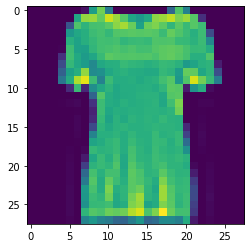

In [ ]:
# dataset shape
print(train_images.shape, test_images.shape)
plt.imshow(train_images[10])



1.   batch, 에폭 용어 
2.   레이어의 활성화 함수 종류(활성화 함수에 따라서 성능이 달라짐)
3.   마지막 dense레이어는 데이터 결과에 맞는 활성화 함수를 사용할 것
4.   optimizer='adam',
      loss='categorical_crossentropy',
      metrics='accuracy'도 결과에 맞춰서 조정할 것


# 데이터 전처리


*   x는 255로 나누어 줘서 0에서 1사이로 변환시켜줌
*   y는 원 핫 인코딩을 적용함



In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, 
                                                  train_labels, 
                                                  test_size = 0.2, 
                                                  random_state=100)

In [ ]:
X_train.shape, X_val.shape

((48000, 28, 28), (12000, 28, 28))

In [ ]:
# the number of classes
num_class = len(np.unique(Y_val))
num_class

10

In [ ]:
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32') / 255.0
X_val = X_val.reshape(X_val.shape[0],28,28,1).astype('float32') / 255.0
# test_images2 = test_images.astype('float32') / 255.0
# print(train_images[0], train_images2[0])

In [ ]:
# make one-hot label
Y_train = keras.utils.to_categorical(Y_train)
Y_val = keras.utils.to_categorical(Y_val)

# 모델

In [ ]:
with strategy.scope():
  # model
  model = keras.models.Sequential([
              keras.layers.Conv2D(8, 5, activation='relu', input_shape=(28, 28, 1)),
              keras.layers.MaxPool2D(pool_size=(3, 3)),
              keras.layers.Conv2D(16, 3, activation='relu'),
              keras.layers.MaxPool2D(pool_size=(2, 2)),
              keras.layers.Flatten(),
              keras.layers.Dense(20, activation='relu'),
              keras.layers.Dense(num_class, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics='accuracy'
  )

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                2900      
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [ ]:
# callback method

# checkpoint path
ckpt_name = 'CNN_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# check checkpoint paht
# if not exist, make dir
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # save model weights, at every epoch
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),
    # EarlyStopping, if val_loss is not improve five times
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1, 
        patience=5
    )
]

In [ ]:
hist = model.fit(X_train, Y_train, validation_data=(X_val,Y_val),
                 callbacks=callbacks_list,
                 batch_size=200,
                 epochs=20)

Epoch 1/20
240/240 [==============================] - 7s 17ms/step - loss: 1.1409 - accuracy: 0.5928 - val_loss: 0.6817 - val_accuracy: 0.7380
Epoch 2/20
240/240 [==============================] - 3s 12ms/step - loss: 0.6126 - accuracy: 0.7679 - val_loss: 0.5663 - val_accuracy: 0.7900
Epoch 3/20
240/240 [==============================] - 3s 13ms/step - loss: 0.5444 - accuracy: 0.7977 - val_loss: 0.5329 - val_accuracy: 0.8056
Epoch 4/20
240/240 [==============================] - 3s 12ms/step - loss: 0.4969 - accuracy: 0.8199 - val_loss: 0.4948 - val_accuracy: 0.8222
Epoch 5/20
240/240 [==============================] - 3s 13ms/step - loss: 0.4647 - accuracy: 0.8317 - val_loss: 0.4729 - val_accuracy: 0.8273
Epoch 6/20
240/240 [==============================] - 3s 12ms/step - loss: 0.4432 - accuracy: 0.8417 - val_loss: 0.4339 - val_accuracy: 0.8426
Epoch 7/20
240/240 [==============================] - 3s 12ms/step - loss: 0.4273 - accuracy: 0.8467 - val_loss: 0.4237 - val_accuracy: 0.8445

In [ ]:
# load last ckpt weight
model.load_weights(checkpoint_path)

# 결과확인하기

In [ ]:
y_pred = model.predict(X_val).round(2)

y_val_label = list(map(np.argmax, Y_val))
y_pred_label = list(map(np.argmax, y_pred))

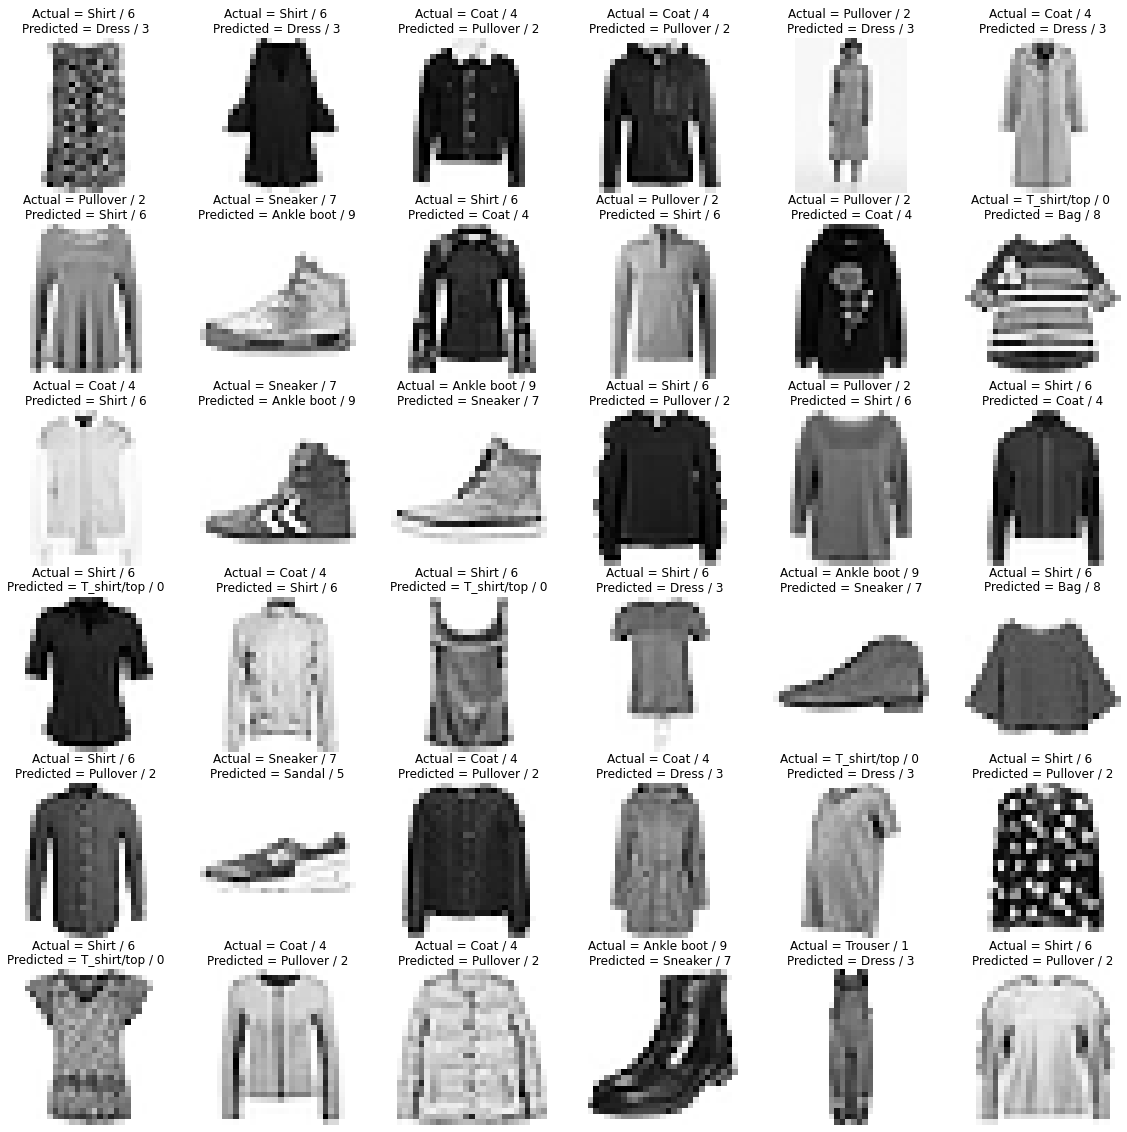

In [ ]:
aaa = np.array(y_val_label) != np.array(y_pred_label)
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               
not_equel_list = np.where(aaa == True)[0]

plt.figure(figsize=(20,20))
j = 1
for i in not_equel_list[0:36]:
# for a in np.random.randint(0,206,36):
#     i = not_equel_list[a]
#     print(a)
    plt.subplot(6,6,j); j+=1
    plt.imshow(X_val[i].reshape(28,28),cmap = 'Greys')
    plt.axis('off')
    plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_names[y_val_label[i]],
                                                            y_val_label[i],
                                                            class_names[y_pred_label[i]],
                                                            y_pred_label[i]))